# **PART 5:** Cluster annotation & visualization
In this tutorial we will combine all the results from TCRex and ClusTCR and attempt to interpret them.

In [1]:
import os
# Set the working directory to the repository directory
os.chdir("/home/sebastiaan/PhD/Repositories/book_chapter/")

In addition to the pandas and numpy libraries, we will import the custom function `merge_results` from the "./src" folder in this repository. This function will perform the necessary steps to merge the original data files (which we will need to remap the J genes), the clustering results and the TCRex results. In this tutorial we will illustrate a basic visualization strategy, which will require the networkx library, as well as the custom `create_edgelist_vgene` function.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

from src.tools import merge_results, create_edgelist_vgene

We start by merging the results for P1 at day 0.

In [3]:
# TCRex results
tcrex = pd.read_csv("./results/tcrex/P1_0_tcrex.tsv", sep = "\t")
# ClusTCR results
clust = pd.read_csv("./results/clustcr/P1_0_clusters.tsv", sep = "\t")
# Original data
rawdata = pd.read_csv("./data/examples/P1_0.tsv", sep = "\t")

merged_0 = merge_results(
    original = rawdata,
    clusters = clust,
    predictions = tcrex
    )

# Drop TCRs that do not belong to any cluster
merged_0 = merged_0.dropna(subset = ["cluster"])

# Select the columns we want to keep
keep = ["duplicate_count",
        "frequency",
        "junction_aa", 
        "v_call", 
        "j_call", 
        "cluster",
        "epitope",
        "pathology",
        "score",
        "bpr"]
merged_0 = merged_0[keep]
# Save results to file
merged_0.to_csv("./results/P1_0_clusters_tcrex.tsv", sep = "\t", index = False)

In [4]:
merged_0.head()

,duplicate_count,frequency,junction_aa,v_call,j_call,cluster,epitope,pathology,score,bpr
0,4444.0,0.001582,CASSEREANEQFF,TRBV6-4*00,TRBJ2-1*00,795.0,NaN,NaN,NaN,NaN
1,2356.0,0.000839,CASSDRSGGADEQFF,TRBV6-4*00,TRBJ2-1*00,437.0,NaN,NaN,NaN,NaN
2,789.0,0.000281,CASSYGAGANVLTF,TRBV6-5*00,TRBJ2-6*00,1263.0,NaN,NaN,NaN,NaN
3,737.0,0.000262,CASSEDGNTEAFF,TRBV6-4*00,TRBJ1-1*00,803.0,NaN,NaN,NaN,NaN
4,730.0,0.000260,CASSEATGGANVLTF,TRBV6-4*00,TRBJ2-6*00,494.0,NaN,NaN,NaN,NaN


We do the same for P1 at day 15 post YFV vaccination.

In [5]:
# TCRex results
tcrex = pd.read_csv("./results/tcrex/P1_15_tcrex.tsv", sep = "\t")
# ClusTCR results
clust = pd.read_csv("./results/clustcr/P1_15_clusters.tsv", sep = "\t")
# Original data
rawdata = pd.read_csv("./data/examples/P1_15.tsv", sep = "\t")

merged_15 = merge_results(
    original = rawdata,
    clusters = clust,
    predictions = tcrex
    )

merged_15 = merged_15.dropna(subset = ["cluster"])

keep = ["duplicate_count",
        "frequency",
        "junction_aa", 
        "v_call", 
        "j_call", 
        "cluster",
        "epitope",
        "pathology",
        "score",
        "bpr"]

merged_15 = merged_15[keep]
merged_15.to_csv("./results/P1_15_clusters_tcrex.tsv", sep = "\t", index = False)

In [6]:
merged_15.head()

,duplicate_count,frequency,junction_aa,v_call,j_call,cluster,epitope,pathology,score,bpr
0,1480.0,0.000769,CASSDRSGGADEQFF,TRBV6-4*00,TRBJ2-1*00,243.0,NaN,NaN,NaN,NaN
1,857.0,0.000445,CASSEDPRLQRDEQFF,TRBV6-1*00,TRBJ2-1*00,44.0,NaN,NaN,NaN,NaN
2,687.0,0.000357,CASSDSPTGAYGYTF,TRBV6-1*00,TRBJ1-2*00,267.0,NaN,NaN,NaN,NaN
3,558.0,0.000290,CASSERENTEAFF,TRBV6-4*00,TRBJ1-1*00,607.0,NaN,NaN,NaN,NaN
4,3.0,0.000002,CASSERENTEAFF,TRBV6-1*00,TRBJ1-1*00,607.0,NaN,NaN,NaN,NaN


Now we will select only those cluster that contain at least one TCR with at least one epitope annotation. Next, we will count the number of epitopes within each cluster and sort the data according to the number of (epitope-)annotated TCRs in the cluster (high -> low).

In [23]:
clusters_with_hits = set(merged_0.dropna(subset = "epitope").cluster)
subset = merged_0[merged_0.cluster.isin(clusters_with_hits)]

epi_count = subset.groupby("cluster").count().epitope.sort_index()
cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()

res = pd.concat([epi_count, cluster_size], axis = 1)
res.sort_values(by = "epitope", ascending = False).head(10)

/tmp/ipykernel_165992/946731723.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()


,epitope,cluster
4196.0,112,570
2722.0,84,355
12296.0,75,278
5792.0,63,123
4192.0,53,477
4193.0,41,216
4191.0,28,594
8477.0,27,110
9722.0,26,210
3387.0,25,208


We can perform the same analysis, but this time only looking at a particular pathology of interest. In this case, we are interested in the number of YFV-specific clusters.

In [21]:
clusters_with_hits = set(merged_0[merged_0.pathology=='YellowFeverVirus'].cluster)
subset = merged_0[merged_0.cluster.isin(clusters_with_hits)]

epi_count = subset.groupby("cluster").count().epitope.sort_index()
cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()

res = pd.concat([epi_count, cluster_size], axis = 1)
res.sort_values(by = "epitope", ascending = False).head(10)

/tmp/ipykernel_165992/698708457.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_size = merged_0.cluster.value_counts()[clusters_with_hits].sort_index()


,epitope,cluster


We find no YFV-specific clusters in the day 0 repertoire. We will perform the same strategy at day 15.

In [8]:
clusters_with_yfv = set(merged_15[merged_15.pathology=='YellowFeverVirus'].cluster)
subset = merged_15[merged_15.cluster.isin(clusters_with_yfv)]

epi_count = subset.groupby("cluster").count().epitope.sort_index()
cluster_size = merged_15.cluster.value_counts()[clusters_with_yfv].sort_index()

res = pd.concat([epi_count, cluster_size], axis = 1)
res.sort_values(by = "epitope", ascending = False).head(10)

/tmp/ipykernel_165992/498134811.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_size = merged_15.cluster.value_counts()[clusters_with_yfv].sort_index()


,epitope,cluster
7673.0,14,54


Here we detected one cluster (7673), that contains a few YFV hits. Next, we will briefly illustrate how this cluster can be visualized using the networkx graph library.

/tmp/ipykernel_165992/1401302738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation['color'] = annotation['pathology'].map(color_mapping)
/tmp/ipykernel_165992/1401302738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation['identifier'] = annotation['junction_aa'] + '_' + annotation['v_call']


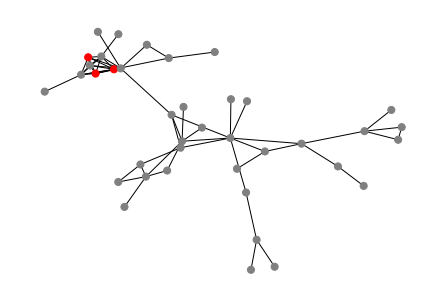

In [9]:
# Create a color mapping
color_mapping = {np.nan:'grey', 'YellowFeverVirus':'red'}

# Map the colors to the epitope annotation, YFV gets red, no annotation gets grey
annotation = subset[["junction_aa", "v_call", "pathology"]]
annotation['color'] = annotation['pathology'].map(color_mapping)
annotation['identifier'] = annotation['junction_aa'] + '_' + annotation['v_call']

# Next, make a dictionary of TCRs with their color
colorlabels = dict(zip(annotation.identifier, annotation.color))

# Identify which TCRs have an edit distance <= 1
edgelist = create_edgelist_vgene(subset)

# Plot the graph
G = nx.from_pandas_edgelist(edgelist)
nx.draw(G, node_color = [colorlabels[i] for i in list(G.nodes())], node_size=50)